## Capstone Final Project - Battle of Neighborhoods

In this project we are analysing the neighborhoods of Toronto to find a best location to start a new Indian restaurant.
Also we are finding the best Indian restaurant available in this location.

### Importing required libraries

In [1]:
import numpy as np 
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

!pip install folium

     |████████████████████████████████| 93 kB 3.0 MB/s  eta 0:00:01


### scrape the Toronto data from Wikipedia page and transform the data in the table into a pandas dataframe

In [2]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df=pd.read_html(url, header=0)[0]

df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### Data cleaning
remove Borough with value Not assigned. more than one neighborhood for a postal code merged. Not assigned neighborhood made same as borough.

In [3]:
df=df[df.Borough !="Not assigned"].reset_index(drop=True)
df=df.groupby(["Postal Code","Borough"], as_index=False).agg(lambda x:",".join(x))
for index, row in df.iterrows():
    if row["Neighbourhood"]=="Not assigned":
        row["Neighbourhood"]=row["Borough"]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [4]:
df.shape

(103, 3)

### Get the latitude and longitude of each postal code

In [5]:
df_geocoder=pd.read_csv('http://cocl.us/Geospatial_data')
df_combined=pd.merge(df,df_geocoder,on='Postal Code')
df_combined.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### importing other required libraries and using foursquare credentials

In [6]:
from geopy.geocoders import Nominatim

In [7]:
import matplotlib.pyplot as  plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium
import requests

In [8]:
CLIENT_ID = 'Z1OC35IESU5GILTPF5APA4DSP4E5LDCBCOS0HDUEJ0P4H04J' # your Foursquare ID
CLIENT_SECRET = 'AFLEGA1LVVDNV5PSASZQ3O4NQWCTKZTF4RNNOEBQZQREWHYA' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30


### Creating a data frame for Toronto Borough

In [11]:
toronto_data = df_combined[df_combined['Borough'].str.contains("Toronto")].reset_index(drop=True)
del toronto_data['Postal Code']
toronto_data.head()

,Borough,Neighbourhood,Latitude,Longitude
0,East Toronto,The Beaches,43.676357,-79.293031
1,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,East Toronto,Studio District,43.659526,-79.340923
4,Central Toronto,Lawrence Park,43.728020,-79.388790


### Defining different functions for the analysis

In [12]:
def geo_location (address) :
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude=location.latitude
    longitude=location.longitude
    return latitude,longitude

def get_venues(lat,long) :
    radius=500
    LIMIT=100
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        long, 
        radius, 
        LIMIT)
    results = requests.get(url).json()
    venue_datas=results['response']['groups'][0]['items']
    venue_details=[]

    for row in venue_datas :
        try :
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_cat=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_cat])
        except KeyError:
            pass

    name_of_columns=['ID', 'Name', 'Category']
    venue_df=pd.DataFrame(venue_details, columns=name_of_columns)
    return venue_df

def get_venue_details(venue_id) :
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    results = requests.get(url).json()
    print(results)
    venue_datas=results['response']['venue']
    
    venue_details=[]
    try :
        venue_id=venue_datas['id']
        venue_name=venue_datas['name']
        venue_likes=venue_datas['likes']['count']
        venue_rating=venue_datas['rating']
        venue_tips=venue_datas['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    name_of_columns=['ID', 'Name', 'Likes','Rating','Tips']
    venue_df=pd.DataFrame(venue_details, columns=name_of_columns)
    return venue_df

### Fetching all the Indian restaurants in Toronto

In [13]:
column_names=['Borough','Neighbourhood','ID','Name']
ind_rest=pd.DataFrame(columns=column_names)
count=1
for row in toronto_data.values.tolist() :
    Borough,Neighbourhood, Latitude, Longitude=row
    venues= get_venues(Latitude,Longitude)
    indian_rest=venues[venues['Category']=='Indian Restaurant']
    print('(',count,'/',len(toronto_data),')','Indian Restaurant in '+Neighbourhood+','+Borough+':'+str(len(indian_rest)))
    print(row)
    for restaurant_details in indian_rest.values.tolist():
        id, name, category=restaurant_details
        ind_rest=ind_rest.append({'Borough': Borough, 'Neighbourhood': Neighbourhood,'ID': id, 'Name': name}, ignore_index=True)
        count+=1

( 1 / 39 ) Indian Restaurant in The Beaches,East Toronto:0
['East Toronto', 'The Beaches', 43.67635739999999, -79.2930312]
( 1 / 39 ) Indian Restaurant in The Danforth West, Riverdale,East Toronto:1
['East Toronto', 'The Danforth West, Riverdale', 43.6795571, -79.352188]
( 2 / 39 ) Indian Restaurant in India Bazaar, The Beaches West,East Toronto:0
['East Toronto', 'India Bazaar, The Beaches West', 43.6689985, -79.31557159999998]
( 2 / 39 ) Indian Restaurant in Studio District,East Toronto:0
['East Toronto', 'Studio District', 43.6595255, -79.340923]
( 2 / 39 ) Indian Restaurant in Lawrence Park,Central Toronto:0
['Central Toronto', 'Lawrence Park', 43.7280205, -79.3887901]
( 2 / 39 ) Indian Restaurant in Davisville North,Central Toronto:0
['Central Toronto', 'Davisville North', 43.7127511, -79.3901975]
( 2 / 39 ) Indian Restaurant in North Toronto West, Lawrence Park,Central Toronto:0
['Central Toronto', 'North Toronto West, Lawrence Park', 43.7153834, -79.40567840000001]
( 2 / 39 ) In

In [16]:
ind_rest.to_csv('Indian_rest_csv.csv')
ind_res_df=pd.read_csv('Indian_rest_csv.csv')
del ind_res_df['Unnamed: 0']

In [17]:
ind_res_df.head()

,Borough,Neighbourhood,ID,Name
0,East Toronto,"The Danforth West, Riverdale",4c1d5337eac020a1cb1048c2,Sher-E-Punjab
1,Central Toronto,Davisville,5169d445e4b07de190b5c3d6,Marigold Indian Bistro
2,Downtown Toronto,"St. James Town, Cabbagetown",4c8c21fdf0ce236ab28e15ef,Butter Chicken Factory
3,Downtown Toronto,Church and Wellesley,4bedf8b5e24d20a17b567214,Kothur Indian Cuisine
4,Downtown Toronto,Central Bay Street,57c07e5f498ed3724a049dc1,Colaba Junction


In [18]:
ind_res_df.shape

(7, 4)

#### There are 7 Indian restaurants are currently available in Toronto Borough

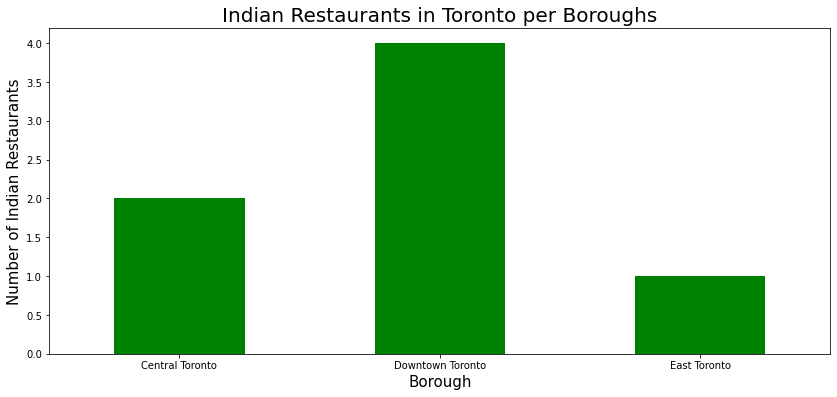

In [19]:
#find the Indian restuarants in different Boroughs in Toronto
ind_res_df.groupby('Borough')['ID'].count().plot.bar(figsize=(14,6),color='green')
plt.title('Indian Restaurants in Toronto per Boroughs', fontsize=20)
plt.xlabel('Borough', fontsize=15)
plt.ylabel('Number of Indian Restaurants', fontsize=15)
plt.xticks(rotation='horizontal')
plt.show()

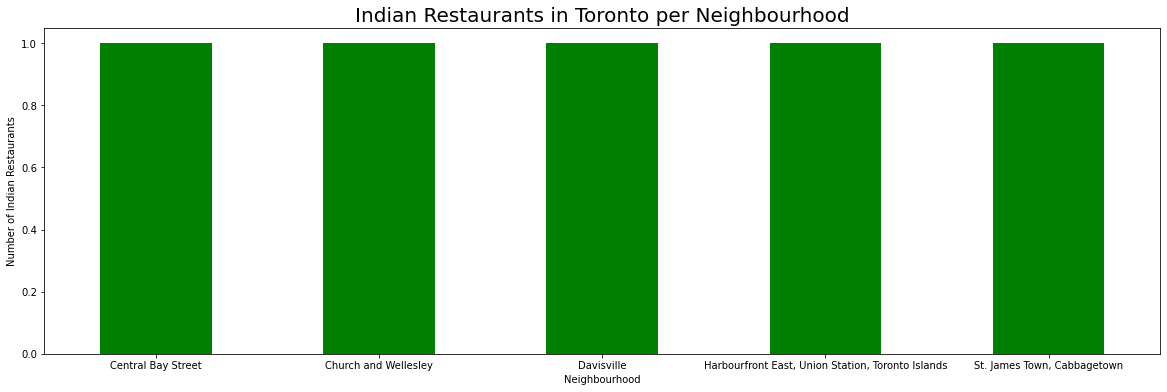

In [20]:
#find the Indian restuarants in different Neighbourhoods in Toronto. Checking only for the largets 5 neighbourhoods
ind_res_df.groupby('Neighbourhood')['ID'].count().nlargest(5).plot.bar(figsize=(20,6),color='green')
plt.title('Indian Restaurants in Toronto per Neighbourhood', fontsize=20)
plt.xlabel('Neighbourhood', fontsize=10)
plt.ylabel('Number of Indian Restaurants', fontsize=10)
plt.xticks(rotation='horizontal')
plt.show()

### Get the rating of currently available Indian restaurants in Toronto

In [21]:
column_names=['Borough','Neighbourhood','ID','Name','Likes','Rating','Tips']
good_ind_rest=pd.DataFrame(columns=column_names)
count=1
for row in ind_res_df.values.tolist() :
    Borough,Neighbourhood, ID, Name=row
    try:
        venue_details= get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available')
        id,name,likes,rating,tips=[0]*5
    
   
    print('(',count,'/',len(ind_res_df),')','processed')
   # print(row)
    #for restaurant_details in indian_rest.values.tolist():
        #id, name, category=restaurant_details
    good_ind_rest=good_ind_rest.append({'Borough': Borough, 'Neighbourhood': Neighbourhood,'ID': id, 'Name': name, 'Likes': likes, 'Rating': rating,'Tips':tips}, ignore_index=True)
    count+=1
good_ind_rest

{'meta': {'code': 200, 'requestId': '5fb922a07694ba313b4b1456'}, 'response': {'venue': {'id': '4c1d5337eac020a1cb1048c2', 'name': 'Sher-E-Punjab', 'contact': {'phone': '4164652125', 'formattedPhone': '(416) 465-2125'}, 'location': {'address': '351 Danforth Ave', 'crossStreet': 'at Jackman Ave', 'lat': 43.67730788939673, 'lng': -79.35306551709385, 'labeledLatLngs': [{'label': 'display', 'lat': 43.67730788939673, 'lng': -79.35306551709385}], 'postalCode': 'M4K 1N7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['351 Danforth Ave (at Jackman Ave)', 'Toronto ON M4K 1N7', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/sherepunjab/4c1d5337eac020a1cb1048c2', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 

,Borough,Neighbourhood,ID,Name,Likes,Rating,Tips
0,East Toronto,"The Danforth West, Riverdale",4c1d5337eac020a1cb1048c2,Sher-E-Punjab,10,7.0,8
1,Central Toronto,Davisville,5169d445e4b07de190b5c3d6,Marigold Indian Bistro,11,8.0,11
2,Downtown Toronto,"St. James Town, Cabbagetown",4c8c21fdf0ce236ab28e15ef,Butter Chicken Factory,17,8.0,11
3,Downtown Toronto,Church and Wellesley,4bedf8b5e24d20a17b567214,Kothur Indian Cuisine,16,8.0,19
4,Downtown Toronto,Central Bay Street,57c07e5f498ed3724a049dc1,Colaba Junction,11,7.1,5
5,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",50b79b94e4b0a577af25a83f,Indian Roti House,38,7.4,14
6,Central Toronto,"The Annex, North Midtown, Yorkville",4c62c59ce1621b8dd0332453,Roti Cuisine of India,39,8.5,19


In [22]:
# Find the avg rating of Indian restaurants in each Neighbourhood
neighbourhood_stat=good_ind_rest.groupby('Neighbourhood', as_index=False).mean()[['Neighbourhood','Rating']]
neighbourhood_stat.columns=['Neighbourhood','Average Rating']
neighbourhood_stat.sort_values(['Average Rating'],ascending=False)

,Neighbourhood,Average Rating
5,"The Annex, North Midtown, Yorkville",8.5
1,Church and Wellesley,8.0
2,Davisville,8.0
4,"St. James Town, Cabbagetown",8.0
3,"Harbourfront East, Union Station, Toronto Islands",7.4
0,Central Bay Street,7.1
6,"The Danforth West, Riverdale",7.0


In [23]:
#Find the avg rating of Indian restaurants in each Borough
borough_stat=good_ind_rest.groupby('Borough', as_index=False).mean()[['Borough','Rating']]
borough_stat.columns=['Borough','Average Rating']
borough_stat.sort_values(['Average Rating'],ascending=False)

,Borough,Average Rating
0,Central Toronto,8.250
1,Downtown Toronto,7.625
2,East Toronto,7.000


In [24]:
neighbourhood_stat=pd.merge(neighbourhood_stat,toronto_data, on ='Neighbourhood')
neighbourhood_stat

,Neighbourhood,Average Rating,Borough,Latitude,Longitude
0,Central Bay Street,7.1,Downtown Toronto,43.657952,-79.387383
1,Church and Wellesley,8.0,Downtown Toronto,43.665860,-79.383160
2,Davisville,8.0,Central Toronto,43.704324,-79.388790
3,"Harbourfront East, Union Station, Toronto Islands",7.4,Downtown Toronto,43.640816,-79.381752
4,"St. James Town, Cabbagetown",8.0,Downtown Toronto,43.667967,-79.367675
5,"The Annex, North Midtown, Yorkville",8.5,Central Toronto,43.672710,-79.405678
6,"The Danforth West, Riverdale",7.0,East Toronto,43.679557,-79.352188


In [29]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=geo_location('Toronto'), zoom_start=11)

# add markers to map
for lat, lng, label in zip(neighbourhood_stat['Latitude'], neighbourhood_stat['Longitude'], neighbourhood_stat['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Findings
1. There are 7 Indian restaurants in Toronto.
2. Most of the Indian restaurants are in Downtown Toronto.
3. Indian resturants in Central Toronto has the highest average rating.
4. If a 